# Gold Price: Comprehensive Time Series Forecasting

This notebook builds an end-to-end forecasting benchmark on gold prices using multiple technique families:

- Baselines: Naive, Moving Average, Drift
- Statistical models: Exponential Smoothing (SES, Holt, Holt-Winters), SARIMAX
- Decomposable model: Prophet
- Machine learning regressors: Linear, Random Forest, XGBoost, LightGBM, CatBoost
- Deep learning: LSTM

The workflow uses strict time-based splits and compares all models with consistent metrics and visualizations.

In [3]:
import os
import warnings
from pathlib import Path

os.environ.setdefault("MPLCONFIGDIR", "/tmp/mpl-cache")
os.environ.setdefault("XDG_CACHE_HOME", "/tmp/xdg-cache")
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

try:
    from xgboost import XGBRegressor
except Exception:
    XGBRegressor = None

try:
    from lightgbm import LGBMRegressor
except Exception:
    LGBMRegressor = None

try:
    from catboost import CatBoostRegressor
except Exception:
    CatBoostRegressor = None

try:
    from prophet import Prophet
except Exception:
    Prophet = None

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
except Exception:
    tf = None

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

np.random.seed(42)
if tf is not None:
    tf.random.set_seed(42)

pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

# Dataset path: works when run from project root, notebooks/, or Kaggle (input path).
_data_path = Path("gold_historical_data.csv")
if _data_path.exists():
    DATA_PATH = _data_path
elif Path("../gold_historical_data.csv").exists():
    DATA_PATH = Path("../gold_historical_data.csv")
else:
    DATA_PATH = Path("/kaggle/input/gold-price-analysis-10-year-historical-data/gold_historical_data.csv")

In [4]:
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found: {DATA_PATH.resolve()}")

df = pd.read_csv(DATA_PATH, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)
df = df[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]

print(f"Rows: {len(df):,}")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Missing cells: {int(df.isna().sum().sum()):,}")

df.head()

Rows: 2,510
Date range: 2016-02-05 to 2026-01-30
Missing cells: 0


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-02-05,"1,155.599976","1,174.800049","1,146.000000","1,157.800049","1,157.800049",877
1,2016-02-08,"1,173.500000","1,200.400024","1,165.000000","1,197.900024","1,197.900024",931
2,2016-02-09,"1,188.699951","1,199.199951","1,186.699951","1,198.699951","1,198.699951",700
3,2016-02-10,"1,189.800049","1,197.699951","1,182.099976","1,194.699951","1,194.699951",671
4,2016-02-11,"1,205.599976","1,260.800049","1,204.599976","1,247.900024","1,247.900024",995


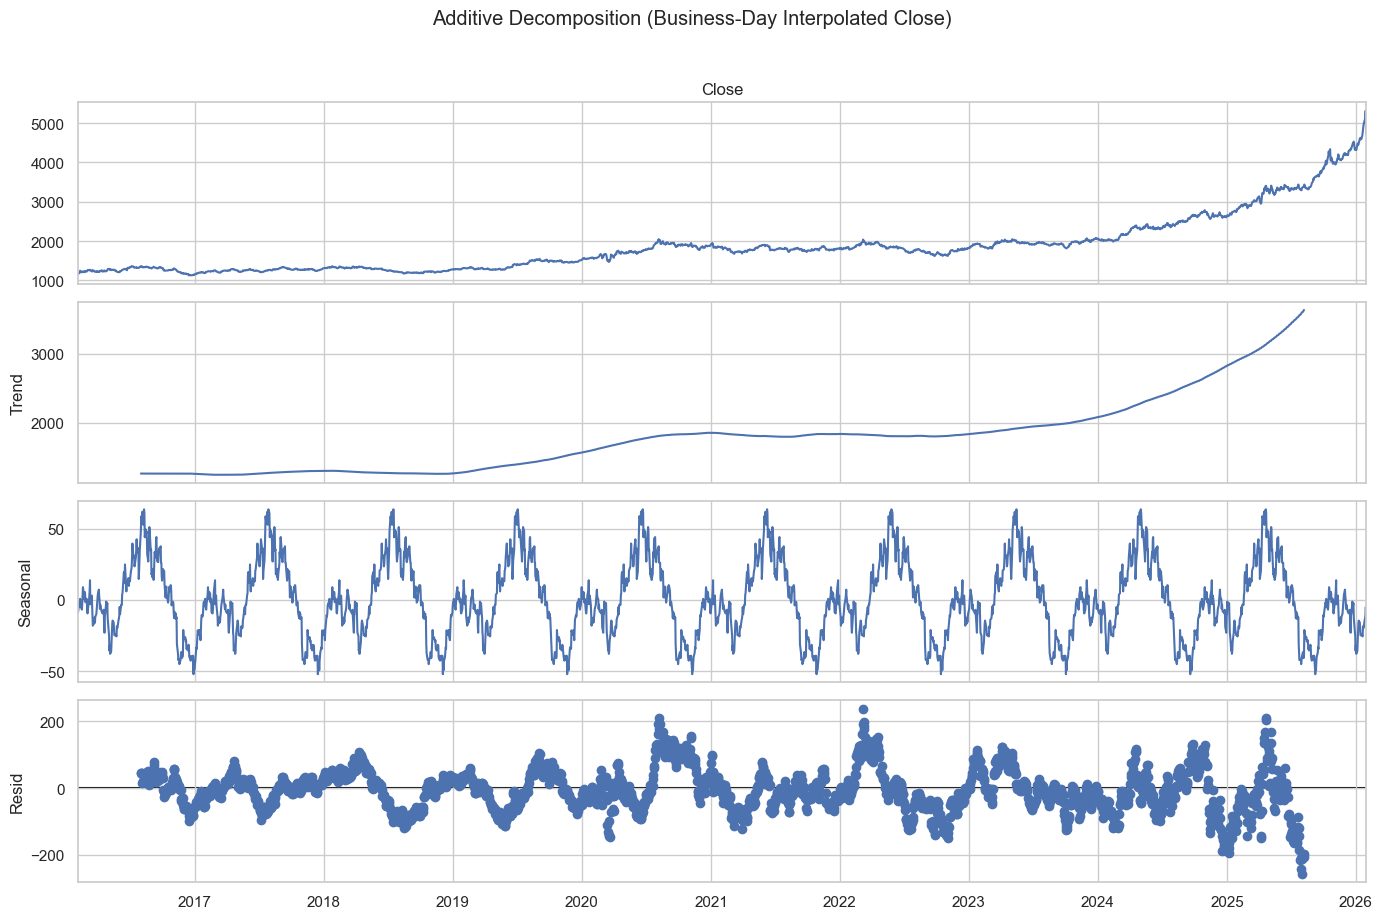

In [5]:
# Decomposition view for exploratory forecasting context.
decomp_source = df.set_index("Date")["Close"].asfreq("B").interpolate(limit_direction="both")
decomposition = seasonal_decompose(decomp_source, model="additive", period=252)

fig = decomposition.plot()
fig.set_size_inches(14, 9)
fig.suptitle("Additive Decomposition (Business-Day Interpolated Close)", y=1.02)
plt.tight_layout()
plt.show()

Train: 2016-02-05 -> 2024-01-30 (2,006)
Val:   2024-01-31 -> 2025-01-30 (252)
Test:  2025-01-31 -> 2026-01-30 (252)


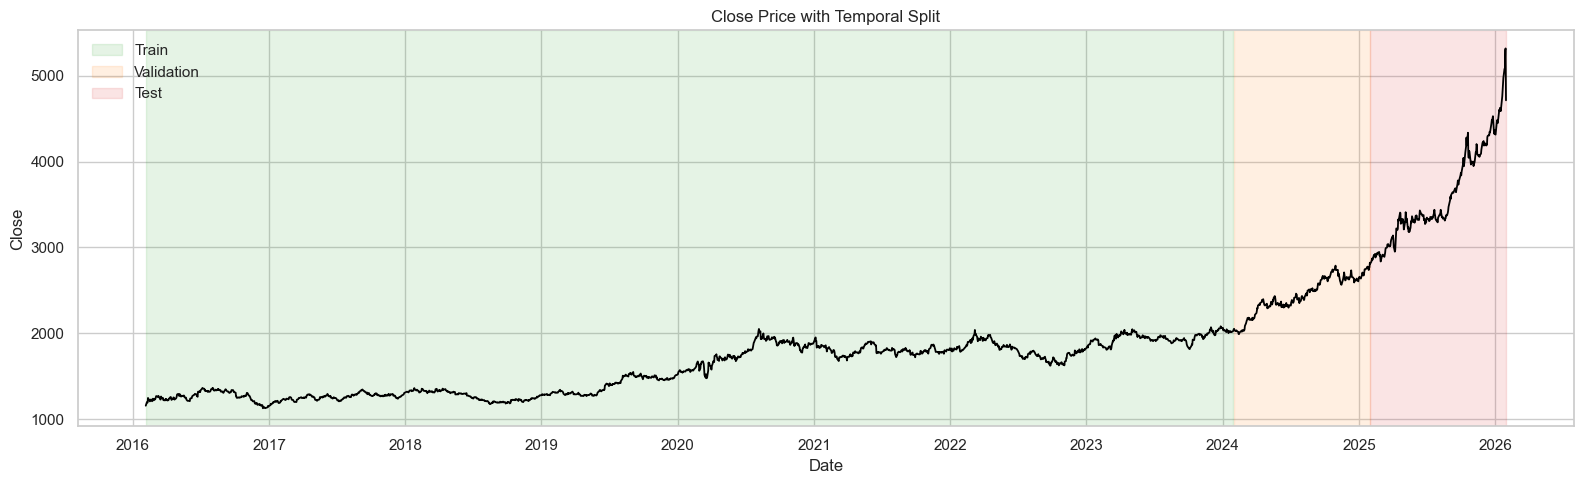

In [6]:
# Time-aware split: train / validation / test.
# Validation and test each use ~1 trading year (252 sessions).
H_TEST = 252
H_VAL = 252

if len(df) <= (H_TEST + H_VAL + 400):
    raise ValueError("Dataset too small for configured split. Increase data length or reduce horizon.")

train = df.iloc[: -(H_VAL + H_TEST)].copy()
val = df.iloc[-(H_VAL + H_TEST): -H_TEST].copy()
test = df.iloc[-H_TEST:].copy()
train_val = df.iloc[:-H_TEST].copy()

print("Train:", train["Date"].min().date(), "->", train["Date"].max().date(), f"({len(train):,})")
print("Val:  ", val["Date"].min().date(), "->", val["Date"].max().date(), f"({len(val):,})")
print("Test: ", test["Date"].min().date(), "->", test["Date"].max().date(), f"({len(test):,})")

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(df["Date"], df["Close"], color="black", linewidth=1.3)
ax.axvspan(train["Date"].min(), train["Date"].max(), alpha=0.12, color="tab:green", label="Train")
ax.axvspan(val["Date"].min(), val["Date"].max(), alpha=0.12, color="tab:orange", label="Validation")
ax.axvspan(test["Date"].min(), test["Date"].max(), alpha=0.12, color="tab:red", label="Test")
ax.set_title("Close Price with Temporal Split")
ax.set_xlabel("Date")
ax.set_ylabel("Close")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [7]:
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred) + 1e-8
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)


def evaluate_forecast(model_name, y_true, y_pred):
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100.0 * np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8)))
    smape_val = smape(y_true, y_pred)

    if len(y_true) > 1:
        dir_acc = float((np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))).mean())
    else:
        dir_acc = np.nan

    return {
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE(%)": mape,
        "sMAPE(%)": smape_val,
        "Directional_Accuracy": dir_acc,
    }


def plot_forecast(actual_index, actual_values, pred_dict, title, top_n=None):
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(actual_index, actual_values, label="Actual", color="black", linewidth=2)

    items = list(pred_dict.items())
    if top_n is not None:
        items = items[:top_n]

    for name, pred in items:
        ax.plot(actual_index, pred, linewidth=1.5, alpha=0.85, label=name)

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Close")
    ax.legend(loc="best", ncol=2)
    plt.tight_layout()
    plt.show()

In [8]:
# Store test forecasts in one place for leaderboard comparison.
predictions_test = {}
metrics_rows = []

y_test = test["Close"].values
test_index = test["Date"]

## 1) Baseline Forecasts

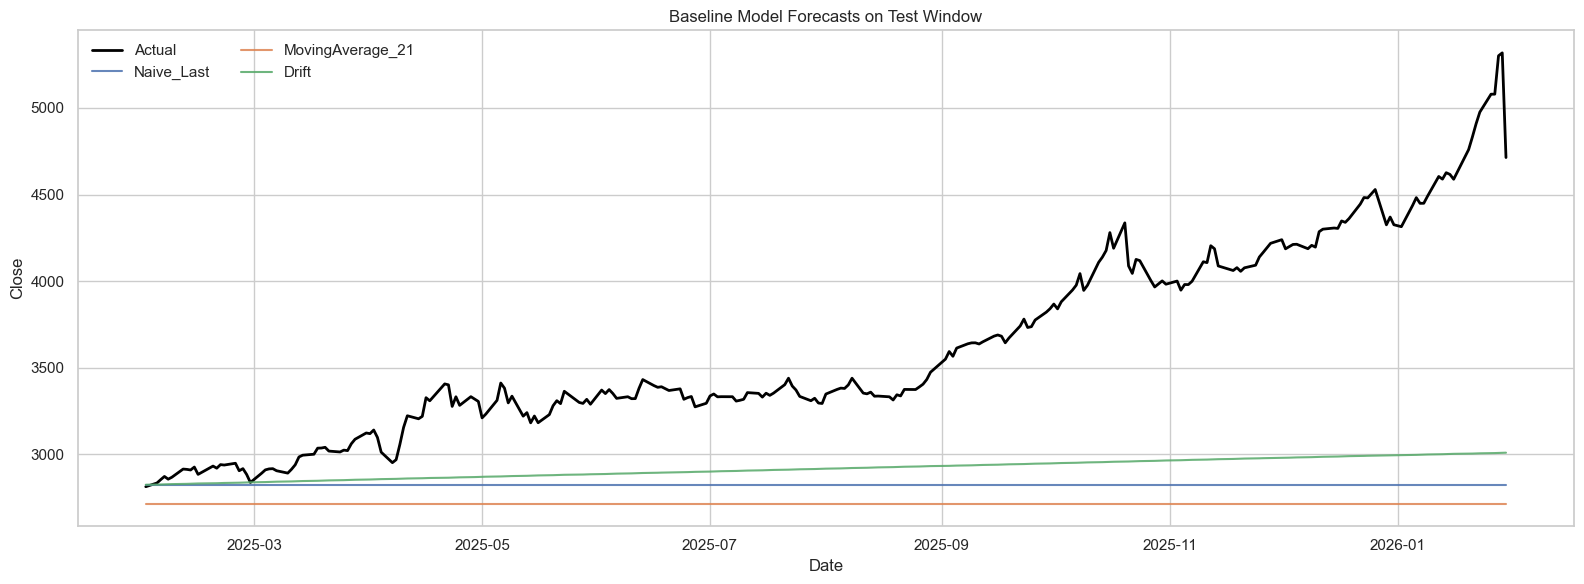

In [9]:
train_val_close = train_val["Close"].values
h = len(test)

# Naive (last observed value)
naive_pred = np.repeat(train_val_close[-1], h)
predictions_test["Naive_Last"] = naive_pred
metrics_rows.append(evaluate_forecast("Naive_Last", y_test, naive_pred))

# Rolling mean baseline (last 21 trading days)
ma_window = 21
ma_pred = np.repeat(np.mean(train_val_close[-ma_window:]), h)
predictions_test["MovingAverage_21"] = ma_pred
metrics_rows.append(evaluate_forecast("MovingAverage_21", y_test, ma_pred))

# Drift (linear extrapolation from first to last train_val point)
drift = (train_val_close[-1] - train_val_close[0]) / (len(train_val_close) - 1)
drift_pred = train_val_close[-1] + drift * np.arange(1, h + 1)
predictions_test["Drift"] = drift_pred
metrics_rows.append(evaluate_forecast("Drift", y_test, drift_pred))

plot_forecast(test_index, y_test, {
    "Naive_Last": naive_pred,
    "MovingAverage_21": ma_pred,
    "Drift": drift_pred,
}, "Baseline Model Forecasts on Test Window")

## 2) Statistical Forecasting Models

In [10]:
series_train_val = pd.Series(train_val["Close"].values, index=train_val["Date"])

# SES
ses_fit = SimpleExpSmoothing(series_train_val).fit(optimized=True)
ses_pred = ses_fit.forecast(len(test)).values
predictions_test["SES"] = ses_pred
metrics_rows.append(evaluate_forecast("SES", y_test, ses_pred))

# Holt linear trend
holt_fit = Holt(series_train_val).fit(optimized=True)
holt_pred = holt_fit.forecast(len(test)).values
predictions_test["Holt"] = holt_pred
metrics_rows.append(evaluate_forecast("Holt", y_test, holt_pred))

# Holt-Winters additive trend + weekly-like seasonality (5 trading days)
hw_fit = ExponentialSmoothing(
    series_train_val,
    trend="add",
    seasonal="add",
    seasonal_periods=5,
).fit(optimized=True)
hw_pred = hw_fit.forecast(len(test)).values
predictions_test["HoltWinters_Add_5"] = hw_pred
metrics_rows.append(evaluate_forecast("HoltWinters_Add_5", y_test, hw_pred))

In [11]:
# SARIMAX order selection via validation RMSE, then refit on train+val.
series_train = pd.Series(train["Close"].values, index=train["Date"])
series_val = pd.Series(val["Close"].values, index=val["Date"])

order_grid = [
    ((1, 1, 1), (0, 0, 0, 0)),
    ((2, 1, 1), (0, 0, 0, 0)),
    ((1, 1, 2), (0, 0, 0, 0)),
    ((2, 1, 2), (0, 0, 0, 0)),
    ((1, 1, 1), (1, 0, 1, 5)),
    ((2, 1, 1), (1, 0, 1, 5)),
]

selection_rows = []
best_rmse = np.inf
best_cfg = None

for order, seasonal_order in order_grid:
    try:
        model = SARIMAX(
            series_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        fit = model.fit(disp=False)
        pred_val = fit.forecast(steps=len(series_val))
        rmse = np.sqrt(mean_squared_error(series_val.values, pred_val.values))
        selection_rows.append({"order": order, "seasonal_order": seasonal_order, "val_rmse": rmse})
        if rmse < best_rmse:
            best_rmse = rmse
            best_cfg = (order, seasonal_order)
    except Exception:
        continue

selection_df = pd.DataFrame(selection_rows).sort_values("val_rmse").reset_index(drop=True)
selection_df

,order,seasonal_order,val_rmse
0,"(2, 1, 1)","(1, 0, 1, 5)",464.934055
1,"(1, 1, 1)","(1, 0, 1, 5)",464.990637
2,"(2, 1, 1)","(0, 0, 0, 0)",465.062245
3,"(1, 1, 2)","(0, 0, 0, 0)",465.312445
4,"(1, 1, 1)","(0, 0, 0, 0)",465.974753
5,"(2, 1, 2)","(0, 0, 0, 0)",465.987630


Best SARIMAX: (2, 1, 1) (1, 0, 1, 5)


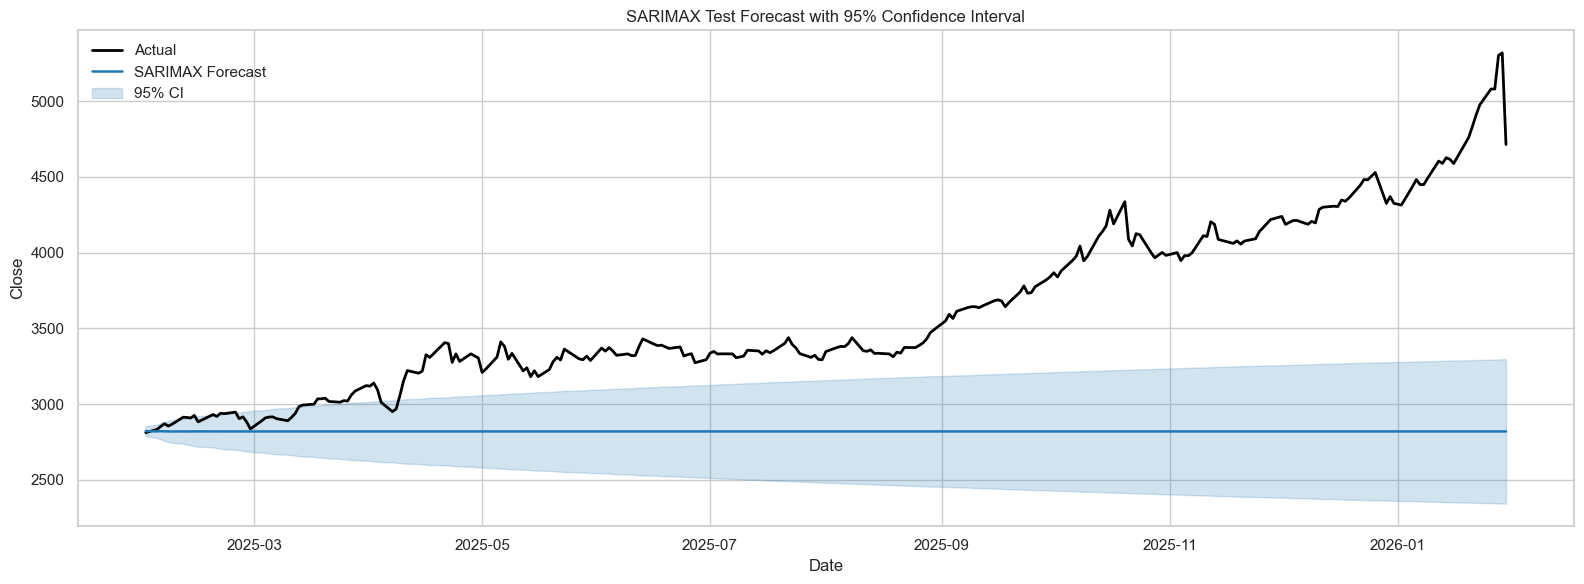

In [12]:
if best_cfg is None:
    raise RuntimeError("SARIMAX selection failed for all candidate configurations.")

best_order, best_seasonal = best_cfg
print("Best SARIMAX:", best_order, best_seasonal)

sarimax_model = SARIMAX(
    series_train_val,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_forecast = sarimax_fit.get_forecast(steps=len(test))
sarimax_pred = sarimax_forecast.predicted_mean.values
sarimax_ci = sarimax_forecast.conf_int(alpha=0.05)

predictions_test["SARIMAX"] = sarimax_pred
metrics_rows.append(evaluate_forecast("SARIMAX", y_test, sarimax_pred))

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(test_index, y_test, label="Actual", color="black", linewidth=2)
ax.plot(test_index, sarimax_pred, label="SARIMAX Forecast", color="tab:blue", linewidth=1.8)
ax.fill_between(
    test_index,
    sarimax_ci.iloc[:, 0].values,
    sarimax_ci.iloc[:, 1].values,
    color="tab:blue",
    alpha=0.2,
    label="95% CI",
)
ax.set_title("SARIMAX Test Forecast with 95% Confidence Interval")
ax.set_xlabel("Date")
ax.set_ylabel("Close")
ax.legend(loc="best")
plt.tight_layout()
plt.show()

## 3) Prophet Forecasting

08:09:02 - cmdstanpy - INFO - Chain [1] start processing
08:09:03 - cmdstanpy - INFO - Chain [1] done processing


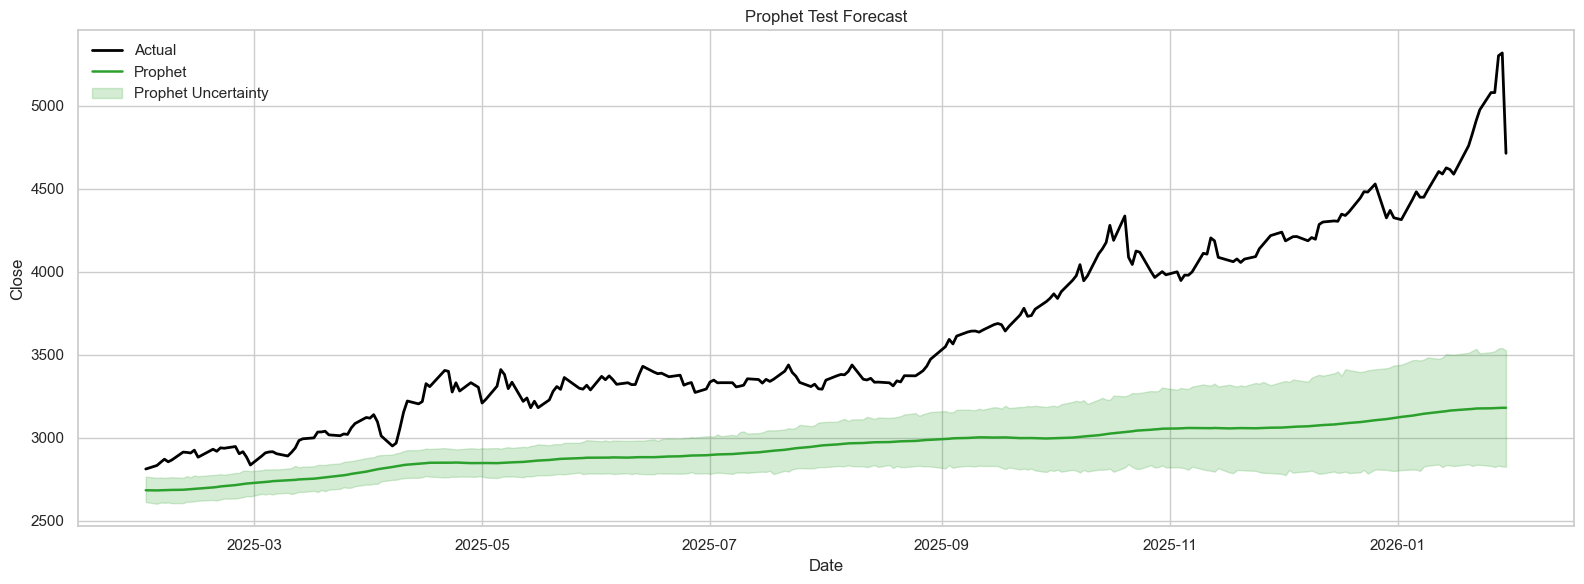

In [13]:
prophet_success = False
if Prophet is None:
    print("Prophet not available; skipping this section.")
else:
    try:
        train_val_prophet = train_val[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"})
        test_prophet = test[["Date"]].rename(columns={"Date": "ds"})

        prophet_model = Prophet(
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True,
            changepoint_prior_scale=0.08,
        )
        prophet_model.fit(train_val_prophet)

        forecast_prophet = prophet_model.predict(test_prophet)
        prophet_pred = forecast_prophet["yhat"].values

        predictions_test["Prophet"] = prophet_pred
        metrics_rows.append(evaluate_forecast("Prophet", y_test, prophet_pred))
        prophet_success = True

        fig, ax = plt.subplots(figsize=(16, 6))
        ax.plot(test_index, y_test, label="Actual", color="black", linewidth=2)
        ax.plot(test_index, prophet_pred, label="Prophet", color="tab:green", linewidth=1.8)
        ax.fill_between(
            test_index,
            forecast_prophet["yhat_lower"].values,
            forecast_prophet["yhat_upper"].values,
            color="tab:green",
            alpha=0.2,
            label="Prophet Uncertainty",
        )
        ax.set_title("Prophet Test Forecast")
        ax.set_xlabel("Date")
        ax.set_ylabel("Close")
        ax.legend(loc="best")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Prophet failed and was skipped: {type(e).__name__}: {e}")

## 4) Machine Learning Forecasting (Lag-Feature Supervised Setup)

In [14]:
def build_lag_features(frame):
    out = frame.copy()
    out = out.sort_values("Date").reset_index(drop=True)

    lag_cols = [1, 2, 3, 5, 10, 21, 42, 63]
    for lag in lag_cols:
        out[f"lag_{lag}"] = out["Close"].shift(lag)

    for w in [5, 10, 21, 63]:
        out[f"roll_mean_{w}"] = out["Close"].shift(1).rolling(w).mean()
        out[f"roll_std_{w}"] = out["Close"].shift(1).rolling(w).std()

    out["return_1"] = out["Close"].pct_change().shift(1)
    out["range_1"] = (out["High"] - out["Low"]).shift(1)
    out["volume_1"] = out["Volume"].shift(1)

    out["dow"] = out["Date"].dt.dayofweek
    out["month"] = out["Date"].dt.month
    out["quarter"] = out["Date"].dt.quarter

    out = out.dropna().reset_index(drop=True)
    return out

feature_df = build_lag_features(df)

split_train_end = train["Date"].max()
split_val_end = val["Date"].max()

train_ml = feature_df[feature_df["Date"] <= split_train_end].copy()
val_ml = feature_df[(feature_df["Date"] > split_train_end) & (feature_df["Date"] <= split_val_end)].copy()
test_ml = feature_df[feature_df["Date"] > split_val_end].copy()

feature_cols = [c for c in feature_df.columns if c not in ["Date", "Adj Close", "Close"]]

X_train, y_train = train_ml[feature_cols], train_ml["Close"]
X_val, y_val = val_ml[feature_cols], val_ml["Close"]
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)
X_test, y_test_ml = test_ml[feature_cols], test_ml["Close"]

print("ML train/val/test sizes:", X_train.shape, X_val.shape, X_test.shape)
print("Test index alignment:", test_ml["Date"].min().date(), "->", test_ml["Date"].max().date())

ML train/val/test sizes: (1943, 26) (252, 26) (252, 26)
Test index alignment: 2025-01-31 -> 2026-01-30


In [15]:
ml_models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=400,
        max_depth=8,
        random_state=42,
        n_jobs=-1,
    ),
}

if XGBRegressor is not None:
    ml_models["XGBoost"] = XGBRegressor(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=4,
    )

if LGBMRegressor is not None:
    ml_models["LightGBM"] = LGBMRegressor(
        n_estimators=600,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
    )

if CatBoostRegressor is not None:
    ml_models["CatBoost"] = CatBoostRegressor(
        depth=6,
        learning_rate=0.03,
        n_estimators=600,
        random_seed=42,
        verbose=False,
    )

for name, model in ml_models.items():
    try:
        model.fit(X_train_val, y_train_val)
        pred = model.predict(X_test)

        aligned = pd.Series(pred, index=test_ml["Date"]).reindex(test_index).values
        predictions_test[name] = aligned
        metrics_rows.append(evaluate_forecast(name, y_test, aligned))
        print(f"{name}: done")
    except Exception as e:
        print(f"{name}: failed -> {type(e).__name__}: {e}")

LinearRegression: done
RandomForest: done
XGBoost: done
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5888
[LightGBM] [Info] Number of data points in the train set: 2195, number of used features: 26
[LightGBM] [Info] Start training from score 1680.302414
LightGBM: done
CatBoost: done


## 5) Deep Learning Forecasting (LSTM)

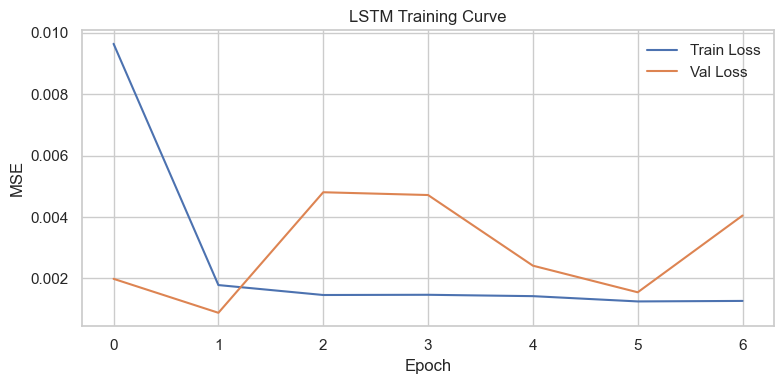

In [16]:
lstm_success = False
if tf is None:
    print("TensorFlow not available; skipping LSTM.")
else:
    try:
        lookback = 30

        all_close = df["Close"].values.reshape(-1, 1)
        train_val_end_idx = df.index[df["Date"] == train_val["Date"].iloc[-1]][0]
        test_start_idx = df.index[df["Date"] == test["Date"].iloc[0]][0]

        scaler = MinMaxScaler()
        scaler.fit(all_close[: train_val_end_idx + 1])
        all_scaled = scaler.transform(all_close).flatten()

        X_seq, y_seq = [], []
        for i in range(lookback, train_val_end_idx + 1):
            X_seq.append(all_scaled[i - lookback:i])
            y_seq.append(all_scaled[i])

        X_seq = np.array(X_seq).reshape(-1, lookback, 1)
        y_seq = np.array(y_seq)

        model_lstm = Sequential([
            LSTM(64, return_sequences=True, input_shape=(lookback, 1)),
            Dropout(0.2),
            LSTM(32),
            Dropout(0.2),
            Dense(1),
        ])
        model_lstm.compile(optimizer="adam", loss="mse")

        es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        history = model_lstm.fit(
            X_seq,
            y_seq,
            epochs=30,
            batch_size=32,
            validation_split=0.15,
            callbacks=[es],
            verbose=0,
        )

        X_test_seq = []
        for i in range(test_start_idx, len(df)):
            X_test_seq.append(all_scaled[i - lookback:i])
        X_test_seq = np.array(X_test_seq).reshape(-1, lookback, 1)

        pred_scaled = model_lstm.predict(X_test_seq, verbose=0).flatten()
        pred_lstm = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

        predictions_test["LSTM"] = pred_lstm
        metrics_rows.append(evaluate_forecast("LSTM", y_test, pred_lstm))
        lstm_success = True

        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(history.history["loss"], label="Train Loss")
        ax.plot(history.history["val_loss"], label="Val Loss")
        ax.set_title("LSTM Training Curve")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("MSE")
        ax.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"LSTM failed and was skipped: {type(e).__name__}: {e}")

## 6) Unified Model Leaderboard

In [17]:
metrics_df = pd.DataFrame(metrics_rows)
metrics_df = metrics_df.drop_duplicates(subset=["Model"], keep="last")
metrics_df = metrics_df.sort_values(["RMSE", "MAE"]).reset_index(drop=True)
metrics_df

,Model,MAE,RMSE,MAPE(%),sMAPE(%),Directional_Accuracy
0,LinearRegression,10.583718,16.231774,0.287076,0.286991,0.868526
1,Holt,132.187041,192.278544,3.518773,3.509432,0.601594
2,LSTM,273.958816,370.449503,6.852739,7.245958,0.549801
3,Prophet,667.457261,793.816710,17.232094,19.336172,0.561753
4,Drift,690.827793,851.990616,17.598427,20.012878,0.601594
5,HoltWinters_Add_5,692.170911,853.117363,17.636183,20.058250,0.577689
6,Naive_Last,784.145231,957.222654,20.033105,23.167226,0.000000
7,SES,785.949519,958.712939,20.084113,23.229960,0.000000
8,SARIMAX,786.667211,959.306843,20.104397,23.254923,0.282869
9,RandomForest,811.833530,979.700108,20.819891,24.134452,0.426295


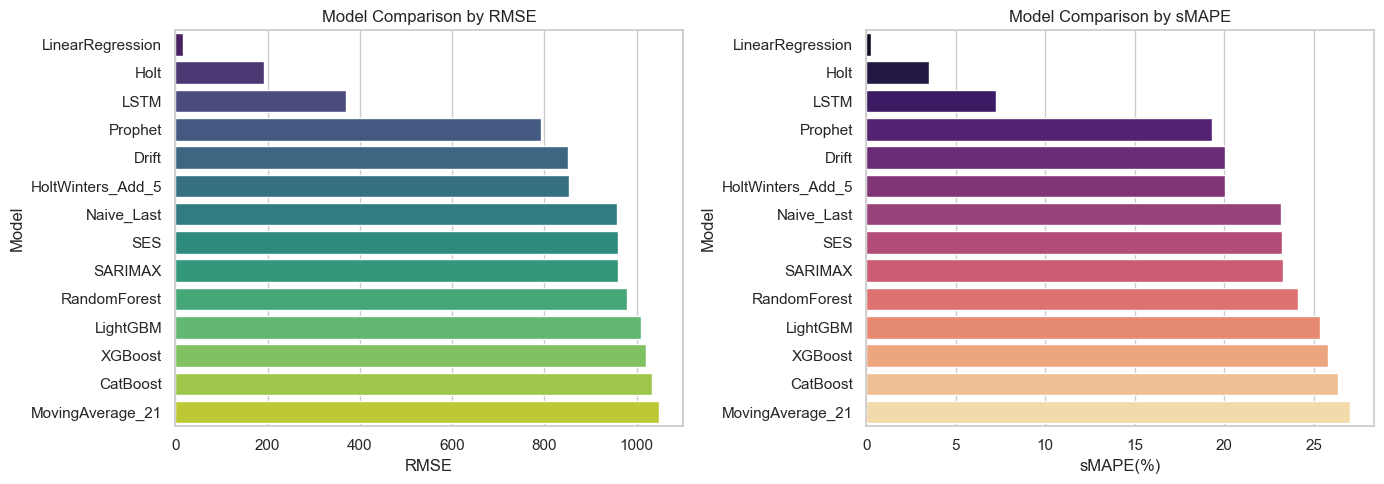

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=metrics_df, y="Model", x="RMSE", ax=axes[0], palette="viridis")
axes[0].set_title("Model Comparison by RMSE")

sns.barplot(data=metrics_df, y="Model", x="sMAPE(%)", ax=axes[1], palette="magma")
axes[1].set_title("Model Comparison by sMAPE")

plt.tight_layout()
plt.show()

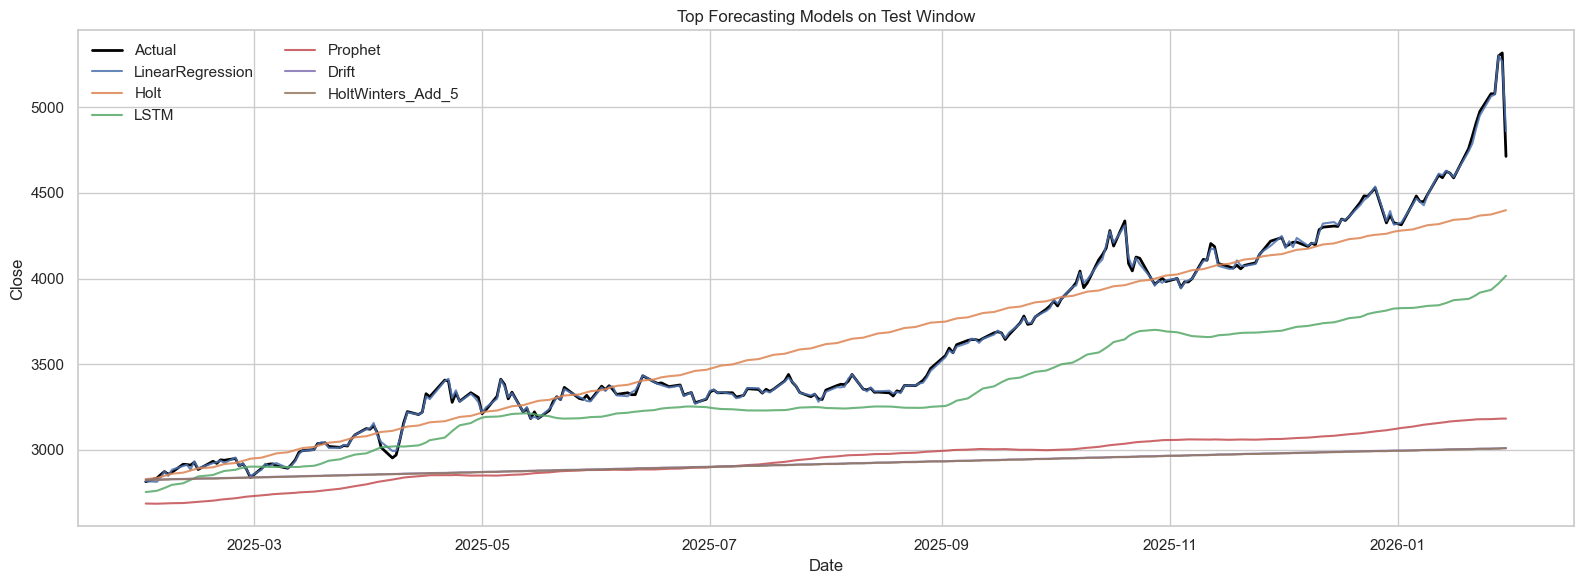

In [19]:
top_models = metrics_df["Model"].head(6).tolist()
top_preds = {m: predictions_test[m] for m in top_models if m in predictions_test}

plot_forecast(
    actual_index=test_index,
    actual_values=y_test,
    pred_dict=top_preds,
    title="Top Forecasting Models on Test Window",
)

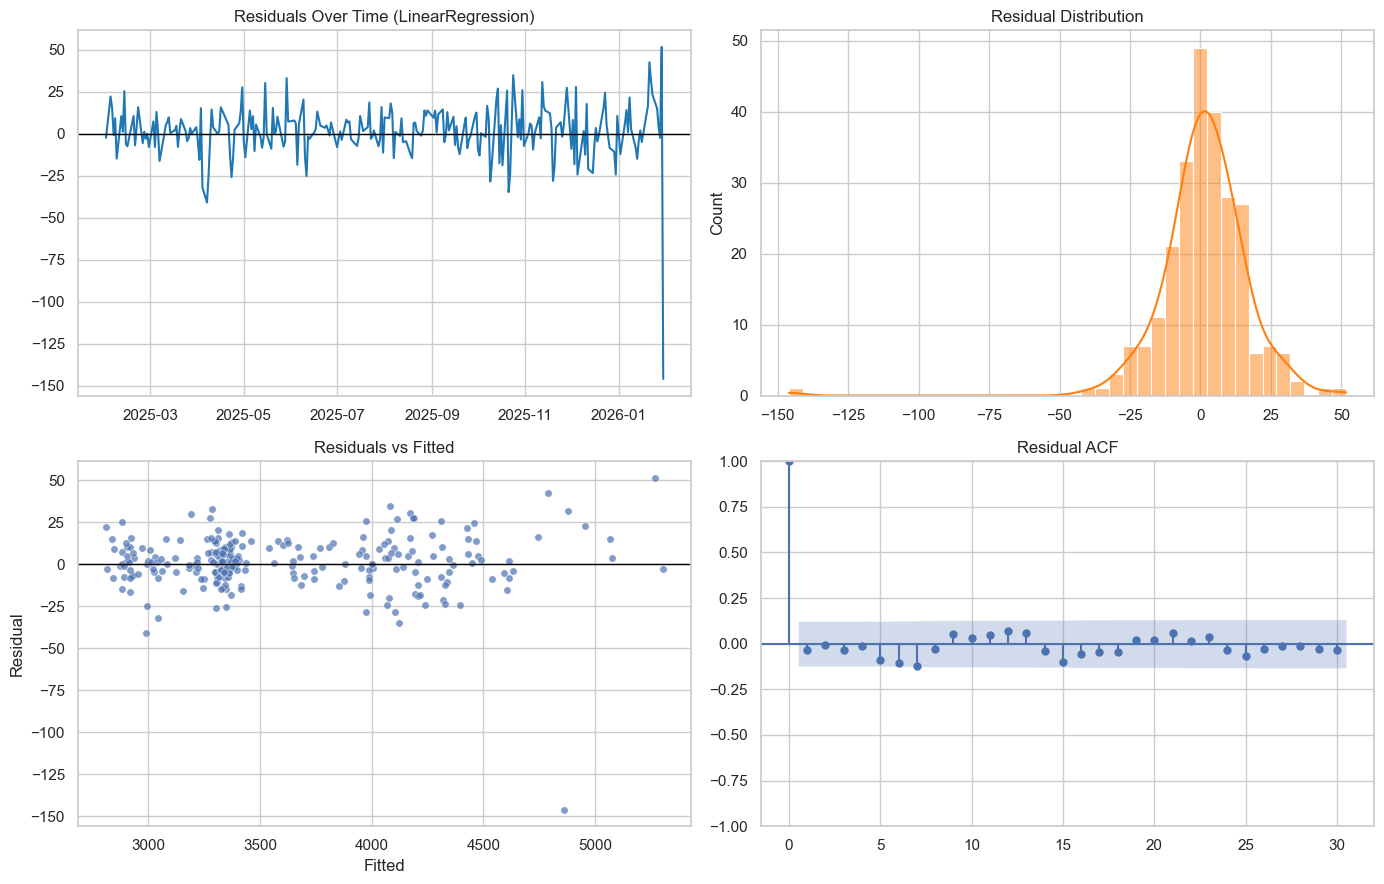

In [20]:
best_model = metrics_df.iloc[0]["Model"]
best_pred = pd.Series(predictions_test[best_model], index=test_index)
residuals = pd.Series(y_test, index=test_index) - best_pred

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

axes[0, 0].plot(test_index, residuals, color="tab:blue")
axes[0, 0].axhline(0, color="black", linewidth=1)
axes[0, 0].set_title(f"Residuals Over Time ({best_model})")

sns.histplot(residuals, bins=40, kde=True, ax=axes[0, 1], color="tab:orange")
axes[0, 1].set_title("Residual Distribution")

sns.scatterplot(x=best_pred, y=residuals, ax=axes[1, 0], s=28, alpha=0.7)
axes[1, 0].axhline(0, color="black", linewidth=1)
axes[1, 0].set_title("Residuals vs Fitted")
axes[1, 0].set_xlabel("Fitted")
axes[1, 0].set_ylabel("Residual")

plot_acf(residuals.dropna(), lags=30, ax=axes[1, 1])
axes[1, 1].set_title("Residual ACF")

plt.tight_layout()
plt.show()

## 7) 60-Business-Day Forward Projection (SARIMAX with Intervals)

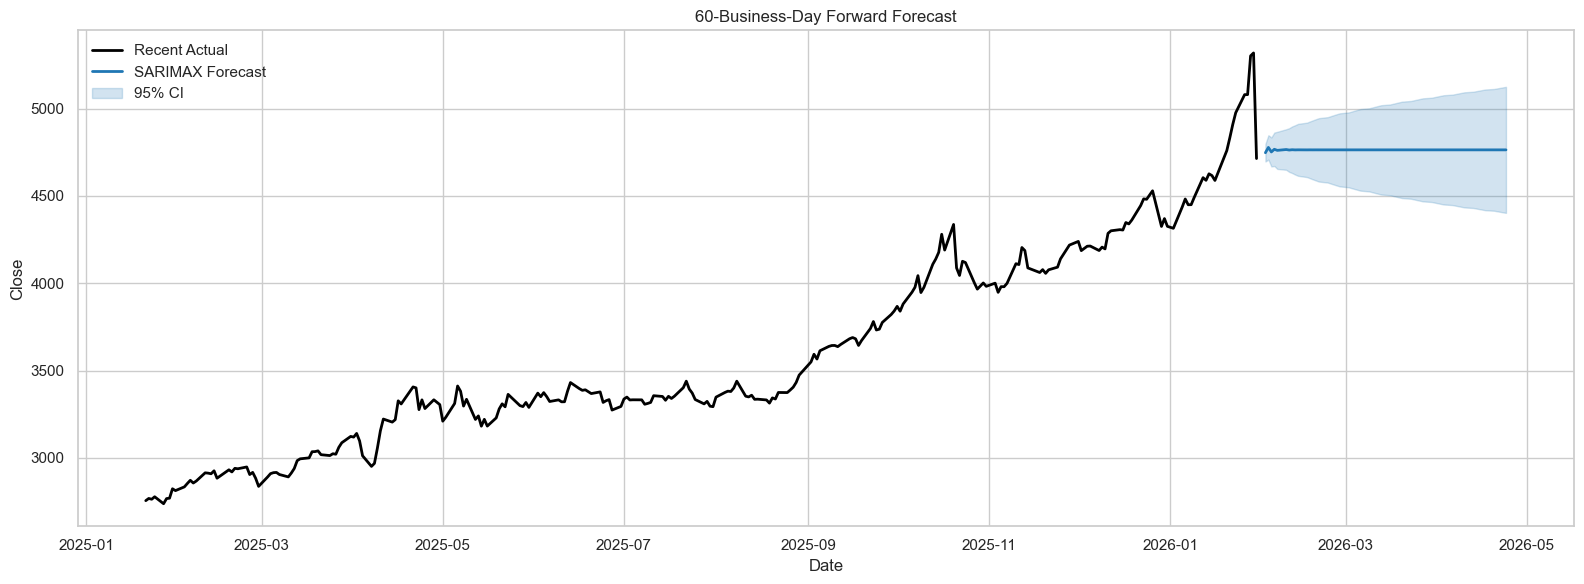

,Date,Forecast,Lower95,Upper95
0,2026-02-02,"4,747.098095","4,696.861316","4,797.334874"
1,2026-02-03,"4,777.462446","4,707.745861","4,847.179030"
2,2026-02-04,"4,751.632390","4,668.562420","4,834.702360"
3,2026-02-05,"4,766.810974","4,671.056295","4,862.565653"
4,2026-02-06,"4,760.617410","4,654.325901","4,866.908919"
5,2026-02-09,"4,765.425951","4,649.295439","4,881.556463"
6,2026-02-10,"4,762.533675","4,637.510266","4,887.557083"
7,2026-02-11,"4,764.235429","4,630.812775","4,897.658084"
8,2026-02-12,"4,763.307457","4,622.036808","4,904.578106"
9,2026-02-13,"4,763.692693","4,614.959365","4,912.426022"


In [21]:
# Fit SARIMAX on full data using previously selected best configuration.
full_series = pd.Series(df["Close"].values, index=df["Date"])
full_model = SARIMAX(
    full_series,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
full_fit = full_model.fit(disp=False)

future_steps = 60
future_fc = full_fit.get_forecast(steps=future_steps)
future_mean = future_fc.predicted_mean
future_ci = future_fc.conf_int(alpha=0.05)

future_dates = pd.bdate_range(start=df["Date"].max() + pd.Timedelta(days=1), periods=future_steps)
future_frame = pd.DataFrame({
    "Date": future_dates,
    "Forecast": future_mean.values,
    "Lower95": future_ci.iloc[:, 0].values,
    "Upper95": future_ci.iloc[:, 1].values,
})

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["Date"].tail(260), df["Close"].tail(260), label="Recent Actual", color="black", linewidth=2)
ax.plot(future_frame["Date"], future_frame["Forecast"], label="SARIMAX Forecast", color="tab:blue", linewidth=2)
ax.fill_between(
    future_frame["Date"],
    future_frame["Lower95"],
    future_frame["Upper95"],
    color="tab:blue",
    alpha=0.2,
    label="95% CI",
)
ax.set_title("60-Business-Day Forward Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Close")
ax.legend(loc="best")
plt.tight_layout()
plt.show()

future_frame.head(10)

## Final Notes

- The leaderboard should guide model choice based on your preferred error metric (RMSE vs sMAPE).
- For production, use walk-forward retraining and monitor drift in residuals.
- A practical next step is model ensembling of top statistical and ML models.